# Customer Segmentation using RFM (Recency, Frequency, Monetary)

## Objective

The primary objective of this project is to apply Customer Segmentation using the RFM (Recency, Frequency, Monetary) model on a real-world retail data. By segmenting customers based on their purchasing behavior, we aim to:

1. Understand customer value and behavior:
    Identify how recently, how often, and how much customers are spending with the business.
2. Segment customers into actionable groups:
    Use K-Means clustering on RFM scores to categorize customers into distinct segments such as:
    - High-value (loyal, frequent, high-spending)
    - Mid-value (occasional buyers with growth potential)
    - Low-value (infrequent or lapsed customers)
3. Enable targeted business strategies:
    These segments will support the marketing and business teams by enabling:
    - Personalized marketing campaigns
    - Better customer retention efforts
    - Resource prioritization towards profitable segments
    - Win-back or upselling strategies for lower-tier segments
4. Demonstrate the power of data-driven customer insights:
    Show how unsupervised learning and customer behavior data can be combined to extract meaningful insights and guide strategic decision-making.

This project serves as a practical example of using unsupervised machine learning in customer analytics and highlights the importance of segmenting users to drive business growth.

### Importing Libraries
In this step, we import essential Python libraries required for data processing (pandas, numpy), data visualization (matplotlib, seaborn), and machine learning (sklearn). I also suppressed warnings to keep our notebook clean.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset
We load the UCI Online Retail dataset, which contains transactional data from a UK-based online store between 2010 and 2011. Each row represents a purchase, with attributes like InvoiceNo, StockCode, Description, Quantity, UnitPrice, CustomerID, and InvoiceDate.

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Exploration & Cleaning
Before analysis, I cleaned the dataset to ensure accuracy:
- Removing rows with missing CustomerIDs (essential for customer-level analysis)
- Removing cancelled transactions
- Filtering out transactions with non-positive quantity or price
- Engineering a TotalPrice column by multiplying quantity and unit price
These steps ensure we're only analyzing valid, completed purchases.

In [3]:
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isna().sum())

Shape: (541909, 8)

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
df = df[df['CustomerID'].notna()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### RFM Metric Calculation
RFM analysis segments customers based on:
- Recency: How recently a customer made a purchase (calculated in days from the most recent purchase)
- Frequency: How often they purchase (number of unique invoices)
- Monetary: How much they’ve spent in total

These metrics are grouped per CustomerID to summarize purchase behavior for each individual.

In [5]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


###  Data Scaling & Elbow Method
Since RFM metrics vary in scale, we standardize them using StandardScaler to prepare for clustering. We then apply the Elbow Method to find the optimal number of clusters (k) by plotting inertia (cluster compactness) for different values of k. The “elbow point” in the graph suggests the best trade-off between cluster count and model performance.

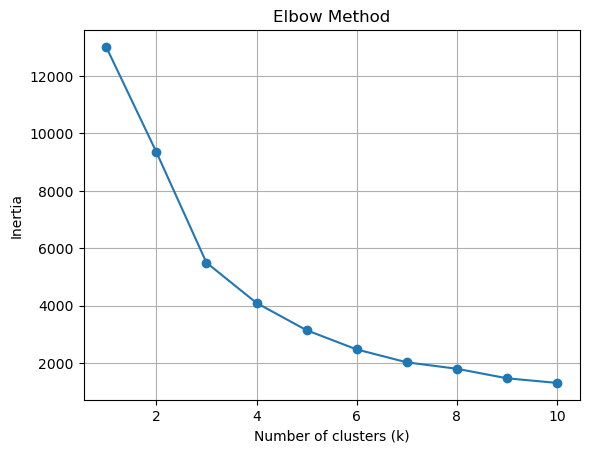

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

### Apply K‑means & label segments
We use the KMeans algorithm to segment customers based on their RFM metrics. The algorithm assigns each customer to one of the k clusters, which groups similar purchasing behaviors together. This enables us to identify different types of customers based on patterns.

In [7]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X)
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


### Scoring & Segment Assignment
We further enhance our segmentation by:
- Converting Recency, Frequency, and Monetary values into quartile-based scores (0–3)
- Summing these to form an RFM_Score (range 0–9)
- Mapping RFM_Score into intuitive customer segments:
    - 0–2: Low Value
    - 3–4: Mid Value
    - 5–9: High Value
      
This helps simplify the interpretation of the clusters for business users.

In [8]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[3, 2, 1, 0]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[0, 1, 2, 3]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[0, 1, 2, 3]).astype(int)

rfm['RFM_Score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

rfm['Segment'] = pd.cut(rfm['RFM_Score'], bins=[-1, 2, 4, 9],
                        labels=['Low Value', 'Mid Value', 'High Value'])

rfm.head()

,Recency,Frequency,Monetary,Cluster,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,3,0,0,3,3,Mid Value
12347.0,2,7,4310.00,0,3,3,3,9,High Value
12348.0,75,4,1797.24,0,1,2,3,6,High Value
12349.0,19,1,1757.55,0,2,0,3,5,High Value
12350.0,310,1,334.40,1,0,0,1,1,Low Value


### Segment Visualization
We use Countplots to see how many customers fall into each segment and Boxplots to compare spending across segments.
These charts provide an overview of customer value distribution and help verify that the clusters make logical sense.

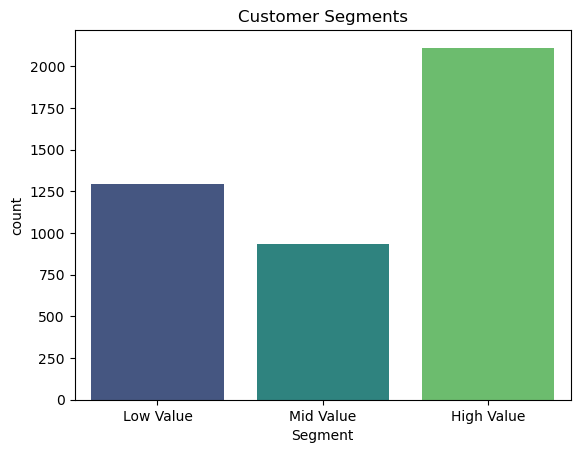

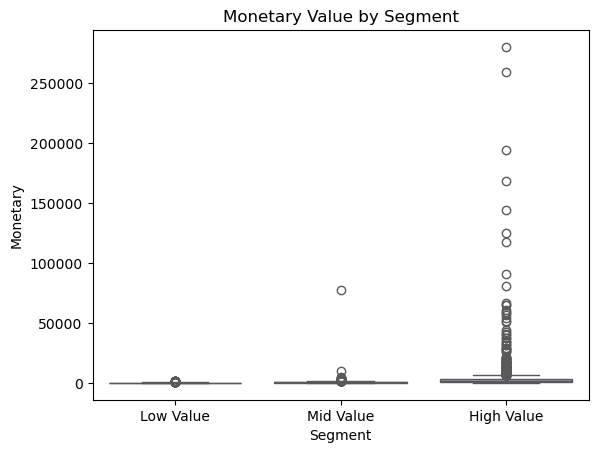

In [9]:
sns.countplot(x='Segment', data=rfm, palette='viridis')
plt.title('Customer Segments')
plt.show()

sns.boxplot(x='Segment', y='Monetary', data=rfm, palette='Set2')
plt.title('Monetary Value by Segment')
plt.show()

### 3D Scatter Plot of Clusters
This plot provides a 3-dimensional view of how customers are spread across Recency, Frequency, and Monetary axes, with colors representing clusters. It’s useful to visually understand how distinct or overlapping the clusters are.

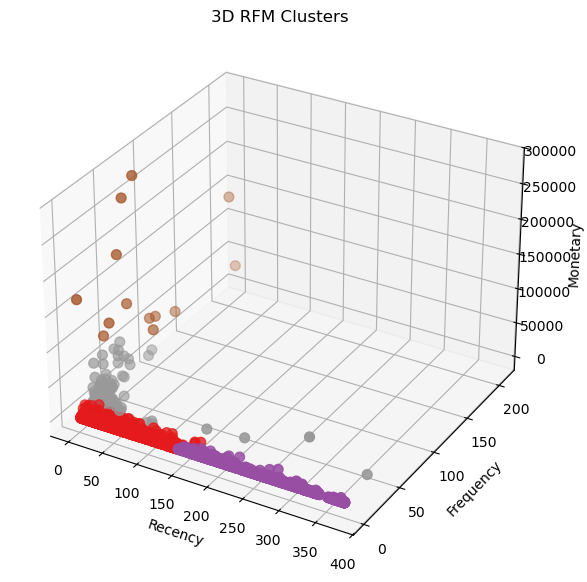

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=rfm['Cluster'], cmap='Set1', s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D RFM Clusters')
plt.show()

### Cluster Summary Table
Finall we compute and display the average Recency, Frequency, and Monetary values for each customer segment. This summary allows us to profile each segment. For example, high-value customers buy frequently, recently, and spend more, which helps guide strategic decisions.

In [11]:
rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
Segment,,,
Low Value,194.000000,1.153369,278.549575
Mid Value,87.365385,1.865385,699.064885
High Value,32.778304,7.246329,3741.106429


### Conclusion & Insights
In this project, we applied the RFM (Recency, Frequency, Monetary) model and K-Means clustering to perform customer segmentation on real-world sales data. After cleaning and transforming over 390,000 valid transaction records, we calculated RFM metrics for each customer and segmented them into meaningful behavioral groups.

Key findings and segment characteristics:
- High Value Customers (R = 33 days, F = 7.2 orders, M = £3,741): Loyal and frequent purchasers with high spending. Ideal for loyalty programs and personalized marketing.
- Mid Value Customers (R = 87 days, F = 1.9 orders, M = £699): Moderately engaged buyers with potential to upgrade. Suitable for cross-sell and reactivation campaigns.
- Low Value Customers (R = 194 days, F = 1.15 orders, M = £279): Infrequent and low-spending users. May need re-engagement strategies or broad-target advertising.

Using the Elbow Method, we determined the optimal number of clusters as k = 4, and applied K-Means to create behaviorally distinct customer groups. We also visualized these segments in both 2D and 3D to assess their separation and interpretability.

This project demonstrates how unsupervised learning can transform raw transactional data into strategic customer intelligence. By leveraging behavioral segmentation:
- Businesses can tailor their marketing efforts to increase retention and revenue.
- Resources can be allocated more efficiently to focus on high-value segments.
- Customer Lifetime Value can be maximized through targeted communication and personalized experiences.

With further refinement, this model can serve as a scalable and practical solution for data-driven customer relationship management.